# Numba
- Uses just-in-time compilation to speed up certain calculations. It takes your function and converts to a machine code with LLVM library. The machine code is being executed whenever you call the function. Note: LLVM is not an acronym, it is the actual name of the project. 
- The main appraoch is to use numba.vectorize and numba.jit() decorator. Decorators modify a function in a uniform way. 
- Numba can parallelize a function on a single machine with multiple CPUs or GPUs. 

### Process vs Threads
<img src=" https://raw.github.com/dmbala/python-bigData/main/Figures/ThreadDiagram.png" width=400 height=400>


| Process                           | Threads |
|:----------------------------------| :---------------------------------- |
| Execution of a program            |A segment of a process (part of the code execution)              |
| More time to create or terminate  |  Less time for create or terminate  |
| Isolated                          |  Shares memory                      |


## Decorators
- Dynamically alters a function or method
- Applies the symbol "@" in front of a function
- A function 'f' can be vectorized with @numba.vectoroize decorator
- A serial function can be parallelized with @numba.jit decorator

## Vectorizing a function
**Example: Evaluate polynomial function in an array**

In [66]:
#Import relevant packages
import numpy as np
import numba
from numba import njit
from numba import jit
import time
numba.__version__

'0.56.4'

Products are vectorized function in NumPy. Here is the NumPy approach.

In [31]:
x = np.arange(int(1e4))
print("Time for executing numpy vectorized function")
%timeit x**3.0 + x**2.0

Time for executing numpy vectorized function
621 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Lets pretent that NumPy does not have a vectorized universal function for the cubic function. Here is the python way of writing a loop. 

In [26]:
import math
def cubic_func(x):
  x_list = []
  for ix in x:
    x_list.append(ix**3.0 + ix**2.0)
  return np.array(x_list)


print("Time for executing non vectorized function")
%timeit cubic_func(x)

Time for executing non vectorized math.sqrt
4.62 ms ± 57.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Here is Numba way to vectorize a function, just use the decorator @numba.vectorize. This is how we create our own universal functions. 

In [32]:
@numba.vectorize
def numba_cubic_func(x):
  return x**3 + x**2
print("Time for executing  @numba.vectorize")
%timeit numba_cubic_func(x)

Time for executing  @numba.vectorize
12 µs ± 7.77 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Python Decorator

In [35]:
# A simple hello world function
def hello():
  print('Hello world')

In [ ]:
hello()

Hello world


In [33]:
# Write a function which takes a function as an argument and returns another function. 
def hello_interactive(func): 
  def wrapper():
    while 1:
      res = input('are you sure you want to greet? [y/n]')
      if res=='n':
        return
      elif res=='y':
        func()
        return
  return wrapper  

In [36]:
result_function = hello_interactive(hello)
print(type(result_function))
print(result_function())

<class 'function'>
are you sure you want to greet? [y/n]y
Hello world
None


Now lets use the above function of function to decorate the hello function. Decorator looks nice, compact, and wrapes th hello function.

In [37]:
@hello_interactive
def hello():
  print('Hello world')
  
hello()

are you sure you want to greet? [y/n]y
Hello world


### Numba Parallelism with @jit decorator
How to improve the performance of lloops? 
1. Vectorization
2. Parallelization

### Example: Monte Carlo PI estimate

<img src="https://raw.githubusercontent.com/dmbala/python-bigData/main/Figures/pi-est.png" width=400 height=400>

In [39]:
import random

# Serial version
def monte_carlo_pi_serial(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

# Parallel version - Explicit with numba.prange 
@jit(nopython=True, parallel=True, nogil=True)
def monte_carlo_pi_explicit_parallel(nsamples):
    acc = 0
    # Only change is applying prange() function. 
    #for i in range(nsamples):
    for i in numba.prange(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [40]:
print("Time for running monte_carlo_pi_serial")
%time monte_carlo_pi_serial(int(1e8))

Time for running monte_carlo_pi_serial
CPU times: user 34.2 s, sys: 68.2 ms, total: 34.3 s
Wall time: 34.3 s


3.14184928

In [41]:
print("Time for running monte_carlo_pi_explicit_parallel")
%time monte_carlo_pi_explicit_parallel(int(1e8))

Time for running monte_carlo_pi_explicit_parallel
CPU times: user 2.7 s, sys: 11.7 ms, total: 2.71 s
Wall time: 1.78 s


3.14160732

## Handling Number of Threads

In [42]:
print(numba.config.NUMBA_NUM_THREADS)

2


In [50]:
from numba import set_num_threads,get_num_threads
import multiprocessing
ncpus = multiprocessing.cpu_count()
print(ncpus)

print(get_num_threads())
set_num_threads(1)
print(get_num_threads())

2
1
1


In [88]:
for i in prange(ncpus):
  set_num_threads(i+1)
  print("Time for running monte_carlo_pi_explicit_parallel for threads", get_num_threads())
  %time monte_carlo_pi_explicit_parallel(int(1e8))

Time for running monte_carlo_pi_explicit_parallel for threads 1
CPU times: user 1.07 s, sys: 2.9 ms, total: 1.07 s
Wall time: 1.07 s
Time for running monte_carlo_pi_explicit_parallel for threads 2
CPU times: user 1.98 s, sys: 1.8 ms, total: 1.98 s
Wall time: 1.01 s


## Parallel Diagnostics

In [75]:

monte_carlo_pi_explicit_parallel.parallel_diagnostics(level=4)

 
 Parallel Accelerator Optimizing:  Function monte_carlo_pi_explicit_parallel, 
<ipython-input-39-a415a36a2843> (14)  


Parallel loop listing for  Function monte_carlo_pi_explicit_parallel, <ipython-input-39-a415a36a2843> (14) 
-----------------------------------------------------|loop #ID
@jit(nopython=True, parallel=True, nogil=True)       | 
def monte_carlo_pi_explicit_parallel(nsamples):      | 
    acc = 0                                          | 
    # Only change is applying prange() function.     | 
    #for i in range(nsamples):                       | 
    for i in numba.prange(nsamples):-----------------| #0
        x = random.random()                          | 
        y = random.random()                          | 
        if (x**2 + y**2) < 1.0:                      | 
            acc += 1                                 | 
    return 4.0 * acc / nsamples                      | 
--------------------------------- Fusing loops ---------------------------------
Attempti

In [89]:
@njit(parallel=True)
def check_parallel(x):
    n = x.shape[0]
    a = np.sin(x)
    b = np.cos(a * a)
    acc = 0
    for i in prange(n - 2):
        for j in prange(n - 1):
            acc += b[i] + b[j + 1]
    return acc

check_parallel(np.arange(10))

check_parallel.parallel_diagnostics(level=4)

 
 Parallel Accelerator Optimizing:  Function check_parallel, <ipython-
input-89-dd015b06c4e1> (1)  


Parallel loop listing for  Function check_parallel, <ipython-input-89-dd015b06c4e1> (1) 
--------------------------------------|loop #ID
@njit(parallel=True)                  | 
def check_parallel(x):                | 
    n = x.shape[0]                    | 
    a = np.sin(x)---------------------| #6
    b = np.cos(a * a)-----------------| #7
    acc = 0                           | 
    for i in prange(n - 2):-----------| #9
        for j in prange(n - 1):-------| #8
            acc += b[i] + b[j + 1]    | 
    return acc                        | 
--------------------------------- Fusing loops ---------------------------------
Attempting fusion of parallel loops (combines loops with similar properties)...
  Trying to fuse loops #6 and #7:
    - fusion succeeded: parallel for-loop #7 is fused into for-loop #6.
  Trying to fuse loops #6 and #9:
    - fusion failed: loop dimension misma

## Numba for node level parallelism

In [90]:
from dask import delayed
@delayed
def mean(*args):
  return sum(args) / len(args)
# Call calc_pi_nogil 10 times with N = 10 million
x = mean(*(delayed(monte_carlo_pi_explicit_parallel)(10**7) for i in range(10)))

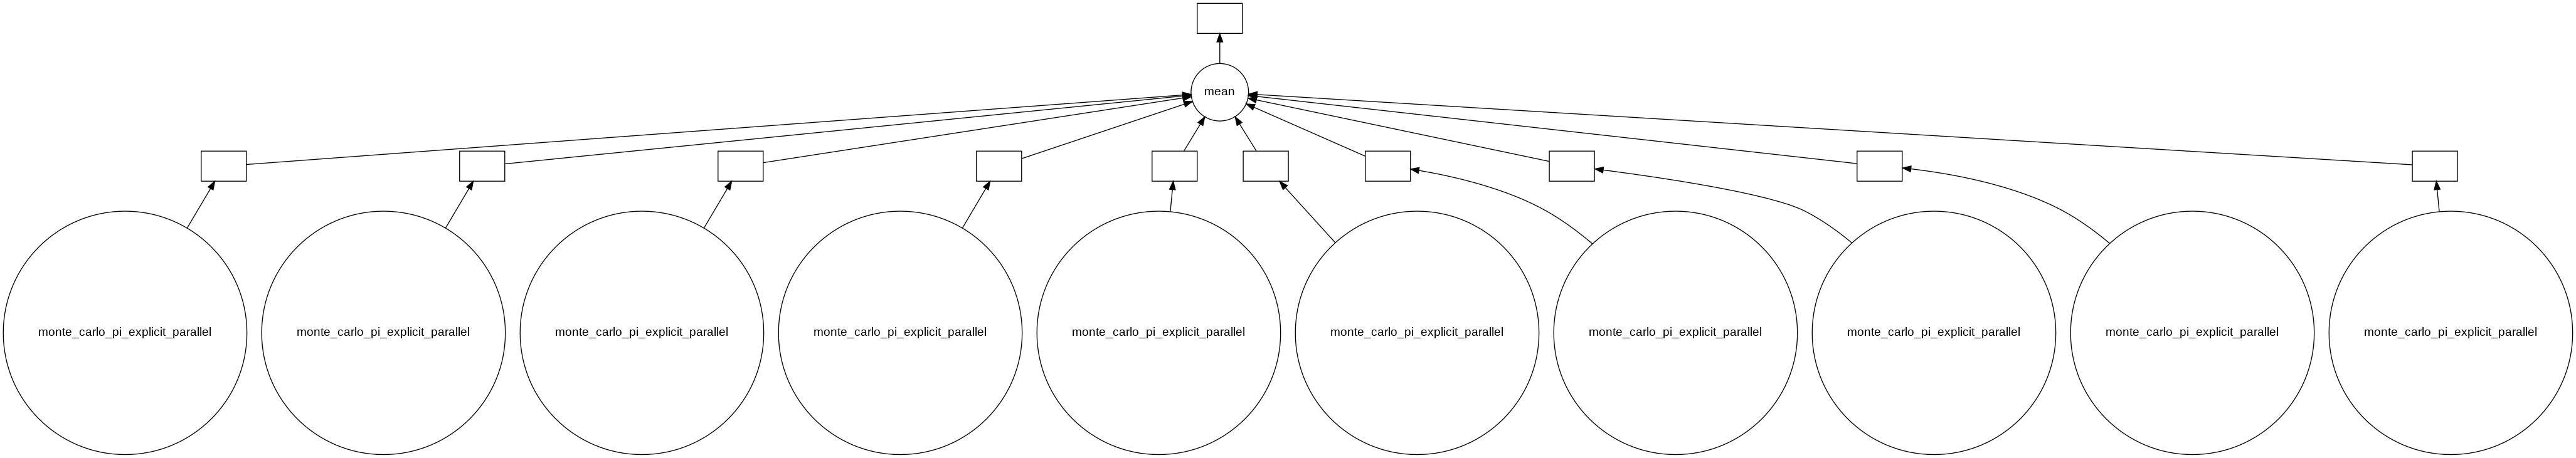

In [91]:
x.visualize()

In [93]:
%timeit x.compute()

1.03 s ± 8.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Numba uses all the available cores by default. Set the shell variable NUMBA_NUM_THREADS before starting the notebook. Dask has fine grained control on threads and processes. 

## Summary
- Numba can easily parallelize a function with JIT
- In a loop, do the explicit parallelism with numba.prange
- Functions can be parallelized to run on GPU hardware (Cuda JIT, not covered)